<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/2.0-CNN-1layer-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Layer CNN x 32 Filters


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/device:GPU:0'

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import importlib
import json

import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

RSTATE = 1
# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(RSTATE)
random.seed(RSTATE)
np.random.seed(RSTATE)


logging.basicConfig(level=logging.INFO)

%matplotlib inline
sns.set()



DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"

SAMPLE_SIZE = "100k"

LEARNING_RATE = 0.01
# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE = 3
PATIENCE = 4

# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 20
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100

DEBUG = False

MODEL_NAME = "CNN"
ARCHITECTURE = f"1x{FILTER1}"
FEATURE_SET_NAME = "embedding_random"
REPORT_FILE = "dl_prototype-report.csv"
if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
  REPORT_FILE = f'test-{REPORT_FILE}'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLE_SIZE}-preprocessed.csv"

ku.ModelWrapper.set_report_filename(REPORT_FILE)

directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"1 Layer CNN with {FILTER1} filters, kernel size 3"





start_time = datetime.now()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv(f"{DATA_FILE}")

In [4]:
df.head()

,star_rating,helpful_votes,total_votes,review_headline,review_body,review_date
0,5,0,0,five star,very good quality price,2015-08-31
1,5,0,0,perfect,finished using trip loved able keep tablet ope...,2015-08-31
2,5,0,0,five star,great product arrived early exactly advertised,2015-08-31
3,5,0,0,five star,work perfectly,2015-08-31
4,2,0,0,expected amazon make better product little,cord still work see crack cord cord would fina...,2015-08-31


In [0]:
rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

**Preprocessing**

In [6]:
# one hot encode ratings
print(rating.shape)
print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
print(y.shape)

(99567,)
<class 'pandas.core.series.Series'>
(99567, 5)


In [7]:


t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews)


reviews_sequences = t.texts_to_sequences(reviews)
reviews_padded = sequence.pad_sequences(reviews_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


X_train, X_test, y_train, y_test = train_test_split(reviews_padded, y, random_state=RSTATE)

Vocabulary size=36517
Number of Documents=99567


# Build our Model

In [0]:
model = Sequential()
model.add(Embedding(len(t.word_counts)+1, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=FILTER1, kernel_size=KERNEL_SIZE, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=LEARNING_RATE), 
              metrics=['categorical_accuracy'])


In [9]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          10955400  
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 250)               400250    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1255      
Total params: 11,385,737
Trainable params: 11,385,737
Non-trainable params: 0
____________________________________________

In [10]:
# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              restore_best_weights=True)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PATIENCE, 
                           verbose=1, 
                           restore_best_weights=True)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
weights_dict = {i: weights[i] for i in np.arange(0, len(weights))}
print(f'class weights: {weights}')
print(f'class weights_dict: {weights_dict}')


mw = ku.ModelWrapper(model, 
                     model_name = MODEL_NAME, 
                     architecture = ARCHITECTURE,
                     feature_set_name = FEATURE_SET_NAME,
                     label_column = LABEL_COLUMN, 
                     feature_column = REVIEW_COLUMN,
                     data_file = DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight=weights_dict,
                      callbacks=[early_stop, reduce_lr])

class weights: [1.4344763  3.05560841 2.18300811 1.18525088 0.37399568]
class weights_dict: {0: 1.4344763002449215, 1: 3.0556084087770445, 2: 2.183008112256084, 3: 1.185250877923933, 4: 0.37399568034557235}
Number of training examples: 74675
Epoch 1/20
467/467 [==============================] - 60s 129ms/step - loss: 1.3119 - categorical_accuracy: 0.4962 - val_loss: 1.1486 - val_categorical_accuracy: 0.5165 - lr: 0.0100
Epoch 2/20
467/467 [==============================] - 59s 127ms/step - loss: 1.1442 - categorical_accuracy: 0.5493 - val_loss: 1.1404 - val_categorical_accuracy: 0.5335 - lr: 0.0100
Epoch 3/20
467/467 [==============================] - 58s 124ms/step - loss: 1.0572 - categorical_accuracy: 0.5706 - val_loss: 1.1601 - val_categorical_accuracy: 0.5077 - lr: 0.0100
Epoch 4/20
467/467 [==============================] - 58s 124ms/step - loss: 0.9922 - categorical_accuracy: 0.5968 - val_loss: 1.1683 - val_categorical_accuracy: 0.5602 - lr: 0.0100
Epoch 5/20
467/467 [==========

Number of test: 24892
Running model.evaluate...
778/778 [==============================] - 3s 4ms/step - loss: 1.1211 - categorical_accuracy: 0.5390
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
(24892, 5)
Getting classification report...
Accuracy: 53.90%


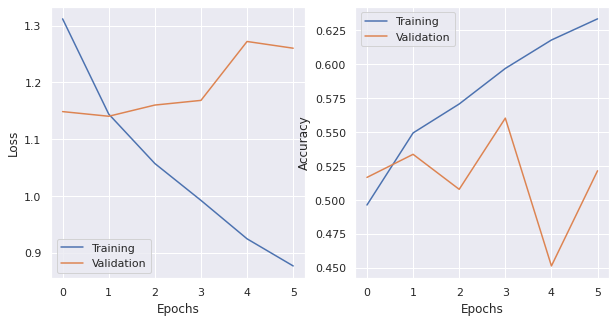


Confusion Matrix
[[2141  938  340   35   46]
 [ 510  572  495   46   29]
 [ 233  629 1008  197  169]
 [  86  342 1415  770 1505]
 [ 116  660 1978 1707 8925]]

Classification Report
              precision    recall  f1-score   support

           1       0.69      0.61      0.65      3500
           2       0.18      0.35      0.24      1652
           3       0.19      0.45      0.27      2236
           4       0.28      0.19      0.22      4118
           5       0.84      0.67      0.74     13386

    accuracy                           0.54     24892
   macro avg       0.44      0.45      0.42     24892
weighted avg       0.62      0.54      0.57     24892



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

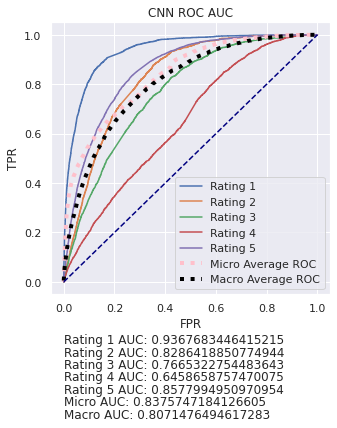

In [11]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))



pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [12]:
print(f'Overall Score: {ru.calculate_metric(mw.crd)}')

INFO:util.report_util:calculating metric from dictionary
INFO:util.report_util:got all values to calculate


Overall Score: 0.37636051575984897


**Save off various files**

In [13]:

mw.save(DRIVE_DIR, append_report=True)


description: CNN-1x32-embedding_random-sampling_none-99567-100-review_body
Saving to report file: drive/My Drive/Springboard/capstone//reports/dl_prototype-report.csv
{'model_name': 'CNN', 'architecture': '1x32', 'description': '1 Layer CNN with 32 filters, kernel size 3', 'feature_column': '{"1": {"precision": 0.6937783538561244, "recall": 0.6117142857142858, "f1-score": 0.650167020953538, "support": 3500}, "2": {"precision": 0.18210760904170648, "recall": 0.34624697336561744, "f1-score": 0.23868141039015234, "support": 1652}, "3": {"precision": 0.1925133689839572, "recall": 0.45080500894454384, "f1-score": 0.26980728051391867, "support": 2236}, "4": {"precision": 0.279491833030853, "recall": 0.18698397280233123, "f1-score": 0.22406518259857414, "support": 4118}, "5": {"precision": 0.8361439010680157, "recall": 0.6667413715822501, "f1-score": 0.7418952618453865, "support": 13386}, "accuracy": 0.538968343242809, "macro avg": {"precision": 0.43680701319613136, "recall": 0.45249832248180

INFO:util.keras_util:Saving tokenizer file: drive/My Drive/Springboard/capstone//models/CNN-1x32-embedding_random-sampling_none-99567-100-review_body-tokenizer.pkl


In [14]:
from tensorflow.keras.models import load_model

model_loaded = load_model(mw.model_file)
scores = model_loaded.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

# this takes too long for real models
if DEBUG == True:
  y_predict = model_loaded.predict(X_test)
  y_predict_unencoded = ku.unencode(y_predict)
  y_test_unencoded = ku.unencode(y_test)

  # classification report
  print(classification_report(y_test_unencoded, y_predict_unencoded))

  # confusion matrix
  print(confusion_matrix(y_test_unencoded, y_predict_unencoded))


778/778 [==============================] - 3s 4ms/step - loss: 1.1211 - categorical_accuracy: 0.5390
Accuracy: 53.90%


In [15]:
end_time = datetime.now()
print(f'Start Time: {start_time}\n' \
      f'End Time: {end_time}\n' \
      f'Total Duration: {round((end_time - start_time).total_seconds() / 60, 2)} mins')
print(datetime.now())

Start Time: 2020-05-01 09:37:20.180485
End Time: 2020-05-01 09:43:42.048229
Total Duration: 6.36 mins
2020-05-01 09:43:42.048431
